# Imports

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, classification_report

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sn

import time, tqdm
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline


seed = 2022
random.seed(seed)

In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.svm import SVC
# from sklearn.model_selection import RepeatedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import gc, os

# Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/Projects/Network security/

/content/drive/My Drive/Projects/Network security


In [ ]:
df = pd.read_csv('ALLFLOWMETER_HIKARI2021.csv')
print(df.shape)
df.head()

(555278, 88)


,Unnamed: 0,Unnamed: 0.1,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,0,0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,1
1,1,1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,...,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,1
2,2,2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,...,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,1
3,3,3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,...,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,1
4,4,4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,...,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML,1


# Preprocess

In [ ]:
id_columns = ['uid', 'originh', 'originp', 'responh', 'responp']
target_columns = ['traffic_category', 'Label']
# drop Unnames columns
df.drop(columns=[col for col in df.columns if 'Unnamed:' in col], inplace=True)

In [ ]:
feature_columns = [
    col for col in df.columns 
        if col not in id_columns + target_columns
]

numerical_columns = [
    col for col in feature_columns 
        if df[col].dtype in [int, np.int64, float, np.float64]
]
categorical_columns = [
    col for col in feature_columns 
        if col not in numerical_columns
]

print(len(numerical_columns), len(categorical_columns))

79 0


In [ ]:
X = df[feature_columns]
Y = df[target_columns[1]]
Y.value_counts()

0    517582
1     37696
Name: Label, dtype: int64

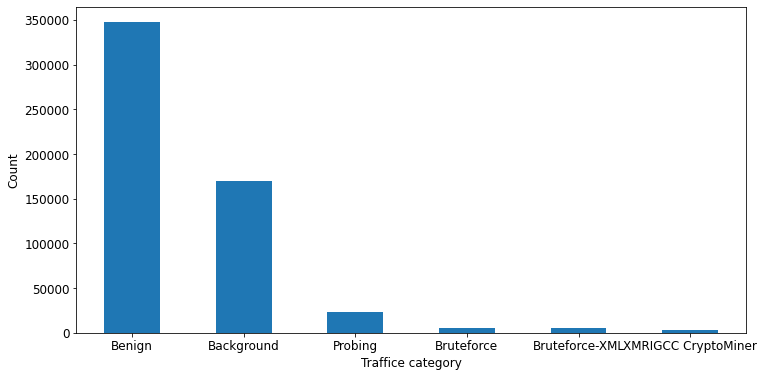

In [ ]:
ax = df['traffic_category'].value_counts().plot(kind='bar', rot=0, figsize=(12, 6), fontsize=12)
ax.set_xlabel('Traffice category', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.savefig('traffic-category-count.pdf', dpi=600)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=seed)

# Utils

In [ ]:
def result(y_true, y_prob, threshold=0.5, verbose=True):
    auc = roc_auc_score(y_true, y_prob)

    y_pred = np.where(y_prob>=threshold, 1, 0)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    if verbose:
      print(f'AUC {auc:.4f}, F1 {f1:.4f}, Precision {precision:.4f}, Recall {recall:.4f}, Accuracy {accuracy:.4f}')

    return auc, f1, precision, recall, accuracy

def print_scores(scores_df):
  endline = ' \\\\ \hline'
  print('\\textbf{Model} & ' + '} & \\textbf{'.join(['\\textbf{auc', 'f1', 'precision', 'recall', 'accuracy}']) + endline)
  model_names = [col for col in scores_df.columns if col != 'Metric']
  for model_name in model_names:
    values = scores_df.loc[:, model_name].values
    result_array =  [str(model_name)] + [str(np.round(value, 3)) for value in values]
    print(' & '.join(result_array) + endline)

# Models

In [ ]:
models = [
    LogisticRegression(random_state=seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=seed),
    
    RandomForestClassifier(random_state=seed, n_jobs=-1),
    GaussianNB(),
    # SVC(random_state=seed),
    # GradientBoostingClassifier(random_state=seed),
    XGBClassifier(eval_metric="logloss", random_state=seed),
    LGBMClassifier(random_state=seed)
]

# Whole dataset

In [ ]:
# LogisticRegression
# AUC 0.3353, F1 0.0073, Precision 0.2593, Recall 0.0037, Accuracy 0.9315
# DecisionTreeClassifier
# AUC 0.5345, F1 0.1356, Precision 0.1194, Recall 0.1570, Accuracy 0.8639
# RandomForestClassifier
# AUC 0.8903, F1 0.1093, Precision 0.1155, Recall 0.1038, Accuracy 0.8850
# GaussianNB
# AUC 0.6295, F1 0.1605, Precision 0.0874, Recall 0.9791, Accuracy 0.3037
# XGBClassifier
# AUC 0.9465, F1 0.1909, Precision 0.5512, Recall 0.1155, Accuracy 0.9335
# LGBMClassifier
# AUC 0.9474, F1 0.3278, Precision 0.4847, Recall 0.2476, Accuracy 0.9309
scores = {'Metric': ['auc', 'f1', 'precision', 'recall', 'accuracy']}

for model in models:
  model_name = model.__class__.__name__
  print(model_name)
  model.fit(x_train, y_train)

  y_prob = model.predict_proba(x_test)[:, -1]
  scores[model_name] = result(y_test, y_prob)

LogisticRegression
AUC 0.3355, F1 0.0060, Precision 0.2150, Recall 0.0030, Accuracy 0.9310
DecisionTreeClassifier
AUC 0.5357, F1 0.1373, Precision 0.1209, Recall 0.1589, Accuracy 0.8635
RandomForestClassifier
AUC 0.8899, F1 0.1058, Precision 0.1120, Recall 0.1003, Accuracy 0.8841
GaussianNB
AUC 0.6284, F1 0.1608, Precision 0.0876, Recall 0.9771, Accuracy 0.3024
XGBClassifier
AUC 0.9462, F1 0.1807, Precision 0.5417, Recall 0.1085, Accuracy 0.9327
LGBMClassifier
AUC 0.9473, F1 0.3236, Precision 0.4812, Recall 0.2438, Accuracy 0.9303


In [ ]:
scores_df = pd.DataFrame(scores)

In [ ]:
print_scores(scores_df)

\textbf{Model} & \textbf{auc} & \textbf{f1} & \textbf{precision} & \textbf{recall} & \textbf{accuracy} \\ \hline
LogisticRegression & 0.336 & 0.006 & 0.215 & 0.003 & 0.931 \\ \hline
DecisionTreeClassifier & 0.536 & 0.137 & 0.121 & 0.159 & 0.863 \\ \hline
RandomForestClassifier & 0.89 & 0.106 & 0.112 & 0.1 & 0.884 \\ \hline
GaussianNB & 0.628 & 0.161 & 0.088 & 0.977 & 0.302 \\ \hline
XGBClassifier & 0.946 & 0.181 & 0.542 & 0.108 & 0.933 \\ \hline
LGBMClassifier & 0.947 & 0.324 & 0.481 & 0.244 & 0.93 \\ \hline


In [ ]:
scores_df.to_csv('result_whole.csv', index=False)

# Undersample

In [ ]:
underSampler = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
x_train_sampled, y_train_sampled = underSampler.fit_resample(x_train, y_train)

In [ ]:
# LogisticRegression
# AUC 0.8890, F1 0.3619, Precision 0.2219, Recall 0.9791, Accuracy 0.7652
# DecisionTreeClassifier
# AUC 0.8691, F1 0.4748, Precision 0.3264, Recall 0.8702, Accuracy 0.8691
# RandomForestClassifier
# AUC 0.9303, F1 0.4839, Precision 0.3247, Recall 0.9494, Accuracy 0.8623
# GaussianNB
# AUC 0.6341, F1 0.1694, Precision 0.0927, Recall 0.9807, Accuracy 0.3458
# XGBClassifier
# AUC 0.9485, F1 0.4959, Precision 0.3297, Recall 0.9997, Accuracy 0.8618
# LGBMClassifier
# AUC 0.9467, F1 0.4985, Precision 0.3321, Recall 0.9992, Accuracy 0.8633
scores = {'Metric': ['auc', 'f1', 'precision', 'recall', 'accuracy']}

for model in models:
  model_name = model.__class__.__name__
  print(model_name)
  model.fit(x_train_sampled, y_train_sampled)

  y_prob = model.predict_proba(x_test)[:, -1]
  scores[model_name] = result(y_test, y_prob)

LogisticRegression
AUC 0.8881, F1 0.3624, Precision 0.2225, Recall 0.9772, Accuracy 0.7648
DecisionTreeClassifier
AUC 0.8648, F1 0.4724, Precision 0.3253, Recall 0.8622, Accuracy 0.8683
RandomForestClassifier
AUC 0.9292, F1 0.4841, Precision 0.3254, Recall 0.9447, Accuracy 0.8622
GaussianNB
AUC 0.6329, F1 0.1696, Precision 0.0929, Recall 0.9784, Accuracy 0.3446
XGBClassifier
AUC 0.9481, F1 0.4983, Precision 0.3318, Recall 0.9996, Accuracy 0.8623
LGBMClassifier
AUC 0.9456, F1 0.5003, Precision 0.3337, Recall 0.9991, Accuracy 0.8635


In [ ]:
scores_df = pd.DataFrame(scores)
print_scores(scores_df)
scores_df.to_csv('result_undersample.csv', index=False)

\textbf{Model} & \textbf{auc} & \textbf{f1} & \textbf{precision} & \textbf{recall} & \textbf{accuracy} \\ \hline
LogisticRegression & 0.888 & 0.362 & 0.222 & 0.977 & 0.765 \\ \hline
DecisionTreeClassifier & 0.865 & 0.472 & 0.325 & 0.862 & 0.868 \\ \hline
RandomForestClassifier & 0.929 & 0.484 & 0.325 & 0.945 & 0.862 \\ \hline
GaussianNB & 0.633 & 0.17 & 0.093 & 0.978 & 0.345 \\ \hline
XGBClassifier & 0.948 & 0.498 & 0.332 & 1.0 & 0.862 \\ \hline
LGBMClassifier & 0.946 & 0.5 & 0.334 & 0.999 & 0.863 \\ \hline


# Undersample + Scaling

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_sampled)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# LogisticRegression
# AUC 0.8825, F1 0.2788, Precision 0.1627, Recall 0.9733, Accuracy 0.6576
# DecisionTreeClassifier
# AUC 0.3824, F1 0.0537, Precision 0.0318, Recall 0.1729, Accuracy 0.5856
# RandomForestClassifier
# AUC 0.4407, F1 0.0032, Precision 0.5455, Recall 0.0016, Accuracy 0.9320
# GaussianNB
# AUC 0.5000, F1 0.0000, Precision 0.0000, Recall 0.0000, Accuracy 0.9320
# XGBClassifier
# AUC 0.3201, F1 0.0475, Precision 0.0272, Recall 0.1870, Accuracy 0.4896
# LGBMClassifier
# AUC 0.3010, F1 0.1192, Precision 0.2011, Recall 0.0847, Accuracy 0.9149

scores = {'Metric': ['auc', 'f1', 'precision', 'recall', 'accuracy']}

for model in models:
  model_name = model.__class__.__name__
  print(model_name)
  model.fit(x_train_scaled, y_train_sampled)

  y_prob = model.predict_proba(x_test_scaled)[:, -1]
  scores[model_name] = result(y_test, y_prob)

LogisticRegression
AUC 0.9195, F1 0.4624, Precision 0.3018, Recall 0.9883, Accuracy 0.8428
DecisionTreeClassifier
AUC 0.8628, F1 0.4702, Precision 0.3238, Recall 0.8584, Accuracy 0.8677
RandomForestClassifier
AUC 0.9291, F1 0.4843, Precision 0.3255, Recall 0.9451, Accuracy 0.8623
GaussianNB
AUC 0.8283, F1 0.2983, Precision 0.1756, Recall 0.9909, Accuracy 0.6810
XGBClassifier
AUC 0.9481, F1 0.4983, Precision 0.3318, Recall 0.9996, Accuracy 0.8623
LGBMClassifier
AUC 0.9468, F1 0.5022, Precision 0.3354, Recall 0.9991, Accuracy 0.8645


In [ ]:
scores_df = pd.DataFrame(scores)
print_scores(scores_df)
scores_df.to_csv('result_scaled.csv', index=False)

\textbf{Model} & \textbf{auc} & \textbf{f1} & \textbf{precision} & \textbf{recall} & \textbf{accuracy} \\ \hline
LogisticRegression & 0.92 & 0.462 & 0.302 & 0.988 & 0.843 \\ \hline
DecisionTreeClassifier & 0.863 & 0.47 & 0.324 & 0.858 & 0.868 \\ \hline
RandomForestClassifier & 0.929 & 0.484 & 0.326 & 0.945 & 0.862 \\ \hline
GaussianNB & 0.828 & 0.298 & 0.176 & 0.991 & 0.681 \\ \hline
XGBClassifier & 0.948 & 0.498 & 0.332 & 1.0 & 0.862 \\ \hline
LGBMClassifier & 0.947 & 0.502 & 0.335 & 0.999 & 0.864 \\ \hline


# Cross validate

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=seed)

In [ ]:
folds = 10
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

scoring = ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']
steps = [
         ('under', RandomUnderSampler(sampling_strategy='majority', random_state=seed)),
        ('model', RandomForestClassifier(random_state=seed))
    ]

## Classifier Selection

In [ ]:
cross_validation_scores = {}

for model in models:
  model_name = model.__class__.__name__
  print(model_name)
  steps[-1] = ('model', model)

  pipeline = Pipeline(steps=steps, verbose=True)
  scores = cross_validate(pipeline, x_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)

  for key in scores.keys():
    mean, std = scores[key].mean(), scores[key].std()
    print(f"{key}, mean {mean:.4f}, std {std:.4f}")
  
  cross_validation_scores[model_name] = scores
  print()

LogisticRegression
fit_time, mean 4.6535, std 0.6745
score_time, mean 0.1671, std 0.0267
test_roc_auc, mean 0.8795, std 0.0101
test_f1, mean 0.3629, std 0.0110
test_precision, mean 0.2233, std 0.0082
test_recall, mean 0.9675, std 0.0091
test_accuracy, mean 0.7696, std 0.0087

DecisionTreeClassifier
fit_time, mean 7.3283, std 0.2334
score_time, mean 0.1996, std 0.0264
test_roc_auc, mean 0.8632, std 0.0049
test_f1, mean 0.4559, std 0.0069
test_precision, mean 0.3161, std 0.0058
test_recall, mean 0.8174, std 0.0098
test_accuracy, mean 0.8678, std 0.0015

RandomForestClassifier
fit_time, mean 48.0036, std 0.5678
score_time, mean 2.8381, std 0.4408
test_roc_auc, mean 0.9292, std 0.0012
test_f1, mean 0.4790, std 0.0066
test_precision, mean 0.3207, std 0.0056
test_recall, mean 0.9462, std 0.0040
test_accuracy, mean 0.8606, std 0.0017

GaussianNB
fit_time, mean 0.7936, std 0.0189
score_time, mean 0.2869, std 0.0171
test_roc_auc, mean 0.6089, std 0.0123
test_f1, mean 0.1664, std 0.0035
test_pre

In [ ]:
scores = {'Metric': scoring}
for model_name in cross_validation_scores.keys():
  scores[model_name] = [cross_validation_scores[model_name][f'test_{score}'].mean() for score in scoring]

scores_df = pd.DataFrame(scores)
scores_df.to_csv('classifier_selection.csv', index=False)
print_scores(scores_df)

\textbf{Model} & \textbf{auc} & \textbf{f1} & \textbf{precision} & \textbf{recall} & \textbf{accuracy} \\ \hline
LogisticRegression & 0.879 & 0.363 & 0.223 & 0.968 & 0.77 \\ \hline
DecisionTreeClassifier & 0.863 & 0.456 & 0.316 & 0.817 & 0.868 \\ \hline
RandomForestClassifier & 0.929 & 0.479 & 0.321 & 0.946 & 0.861 \\ \hline
GaussianNB & 0.609 & 0.166 & 0.091 & 0.979 & 0.335 \\ \hline
XGBClassifier & 0.949 & 0.492 & 0.326 & 0.999 & 0.86 \\ \hline
LGBMClassifier & 0.947 & 0.496 & 0.33 & 0.999 & 0.862 \\ \hline


# Hyper-parameter tuning
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [ ]:
n_estimators = [100, 500]
depths = [None, 3, 5]
learning_rates = [0.1, 0.05]

tunings = {}
for learning_rate in learning_rates:
  for n_estimator in n_estimators:
    for depth in depths:
      print(f"N_estimator {n_estimator}, depth {depth}, learning rate {learning_rate}")
      model = LGBMClassifier(max_depth=depth, n_estimators=n_estimator, learning_rate=learning_rate, random_state=seed)
      
      steps[-1] = ('model', model)

      pipeline = Pipeline(steps=steps, verbose=True)
      scores = cross_validate(pipeline, x_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
      tunings[f'{learning_rate} & {n_estimator} & {depth}'] = scores

      for key in scores.keys():
        mean, std = scores[key].mean(), scores[key].std()
        print(f"{key}, mean {mean:.4f}, std {std:.4f}")
      print()

N_estimator 100, depth None, learning rate 0.1
fit_time, mean 6.4752, std 0.0843
score_time, mean 0.7583, std 0.0258
test_roc_auc, mean 0.9472, std 0.0009
test_f1, mean 0.4958, std 0.0056
test_precision, mean 0.3298, std 0.0050
test_recall, mean 0.9985, std 0.0006
test_accuracy, mean 0.8624, std 0.0014

N_estimator 100, depth 3, learning rate 0.1
fit_time, mean 4.2025, std 0.1031
score_time, mean 0.6777, std 0.0421
test_roc_auc, mean 0.9488, std 0.0007
test_f1, mean 0.4916, std 0.0057
test_precision, mean 0.3261, std 0.0050
test_recall, mean 0.9987, std 0.0007
test_accuracy, mean 0.8600, std 0.0015

N_estimator 100, depth 5, learning rate 0.1
fit_time, mean 5.2266, std 0.1202
score_time, mean 0.8213, std 0.0248
test_roc_auc, mean 0.9493, std 0.0006
test_f1, mean 0.4945, std 0.0059
test_precision, mean 0.3286, std 0.0052
test_recall, mean 0.9987, std 0.0005
test_accuracy, mean 0.8616, std 0.0016

N_estimator 500, depth None, learning rate 0.1
fit_time, mean 21.7628, std 0.3730
score_tim

In [ ]:
print(' & '.join(['learning_rate', 'n_estimator', 'depth'] + ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']))
for key in tunings.keys():
  scores = tunings[key]
  result_array = []
  for score in ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']:
    result_array.append(str(np.round(scores[f'test_{score}'].mean(), 3)))

  result_string = ' & '.join(result_array)
  print(f'{key} & {result_string}  \\\\ \hline')

learning_rate & n_estimator & depth & accuracy & roc_auc & f1 & precision & recall
0.1 & 100 & None & 0.862 & 0.947 & 0.496 & 0.33 & 0.999  \\ \hline
0.1 & 100 & 3 & 0.86 & 0.949 & 0.492 & 0.326 & 0.999  \\ \hline
0.1 & 100 & 5 & 0.862 & 0.949 & 0.494 & 0.329 & 0.999  \\ \hline
0.1 & 500 & None & 0.862 & 0.94 & 0.493 & 0.328 & 0.986  \\ \hline
0.1 & 500 & 3 & 0.863 & 0.948 & 0.496 & 0.33 & 0.999  \\ \hline
0.1 & 500 & 5 & 0.863 & 0.944 & 0.496 & 0.33 & 0.995  \\ \hline
0.05 & 100 & None & 0.862 & 0.949 & 0.496 & 0.33 & 0.999  \\ \hline
0.05 & 100 & 3 & 0.852 & 0.946 & 0.477 & 0.314 & 0.998  \\ \hline
0.05 & 100 & 5 & 0.859 & 0.949 & 0.49 & 0.325 & 0.999  \\ \hline
0.05 & 500 & None & 0.863 & 0.944 & 0.496 & 0.33 & 0.996  \\ \hline
0.05 & 500 & 3 & 0.862 & 0.949 & 0.495 & 0.329 & 0.999  \\ \hline
0.05 & 500 & 5 & 0.863 & 0.947 & 0.496 & 0.33 & 0.998  \\ \hline


# Test Results

In [ ]:
steps[-1] = ('model', LGBMClassifier(max_depth=None, n_estimators=100, learning_rate=0.05, random_state=seed))
pipeline = Pipeline(steps=steps, verbose=True)
cross_validatation_scores = cross_validate(pipeline, x_train, y_train, cv=kf, scoring=scoring, n_jobs=-1, return_estimator=True)

In [ ]:
scores = {'Metric': scoring}
for run, pipeline in enumerate(cross_validatation_scores['estimator']):
  model = pipeline['model']
  y_prob = model.predict_proba(x_test)[:, -1]
  scores[run] = result(y_test, y_prob)

AUC 0.9482, F1 0.5020, Precision 0.3352, Recall 0.9989, Accuracy 0.8644
AUC 0.9483, F1 0.5018, Precision 0.3351, Recall 0.9991, Accuracy 0.8643
AUC 0.9484, F1 0.5020, Precision 0.3353, Recall 0.9988, Accuracy 0.8644
AUC 0.9484, F1 0.5023, Precision 0.3354, Recall 0.9995, Accuracy 0.8645
AUC 0.9485, F1 0.5018, Precision 0.3351, Recall 0.9987, Accuracy 0.8643
AUC 0.9479, F1 0.5019, Precision 0.3351, Recall 0.9991, Accuracy 0.8643
AUC 0.9483, F1 0.5026, Precision 0.3358, Recall 0.9991, Accuracy 0.8648
AUC 0.9481, F1 0.5022, Precision 0.3354, Recall 0.9991, Accuracy 0.8645
AUC 0.9480, F1 0.5024, Precision 0.3356, Recall 0.9987, Accuracy 0.8647
AUC 0.9483, F1 0.5022, Precision 0.3354, Recall 0.9986, Accuracy 0.8646


In [ ]:
scores_df = pd.DataFrame(scores)
scores_df.to_csv('result_test.csv', index=False)
print_scores(scores_df)

\textbf{Model} & \textbf{auc} & \textbf{f1} & \textbf{precision} & \textbf{recall} & \textbf{accuracy} \\ \hline
0 & 0.948 & 0.502 & 0.335 & 0.999 & 0.864 \\ \hline
1 & 0.948 & 0.502 & 0.335 & 0.999 & 0.864 \\ \hline
2 & 0.948 & 0.502 & 0.335 & 0.999 & 0.864 \\ \hline
3 & 0.948 & 0.502 & 0.335 & 0.999 & 0.865 \\ \hline
4 & 0.949 & 0.502 & 0.335 & 0.999 & 0.864 \\ \hline
5 & 0.948 & 0.502 & 0.335 & 0.999 & 0.864 \\ \hline
6 & 0.948 & 0.503 & 0.336 & 0.999 & 0.865 \\ \hline
7 & 0.948 & 0.502 & 0.335 & 0.999 & 0.865 \\ \hline
8 & 0.948 & 0.502 & 0.336 & 0.999 & 0.865 \\ \hline
9 & 0.948 & 0.502 & 0.335 & 0.999 & 0.865 \\ \hline


In [ ]:
mean_df = scores_df[[col for col in scores_df.columns if col!='Metric']].mean(axis=1).reset_index(drop=True)
mean_df.index = scoring

In [ ]:
mean_df

roc_auc      0.948241
f1           0.502109
precision    0.335329
recall       0.998947
accuracy     0.864478
dtype: float64

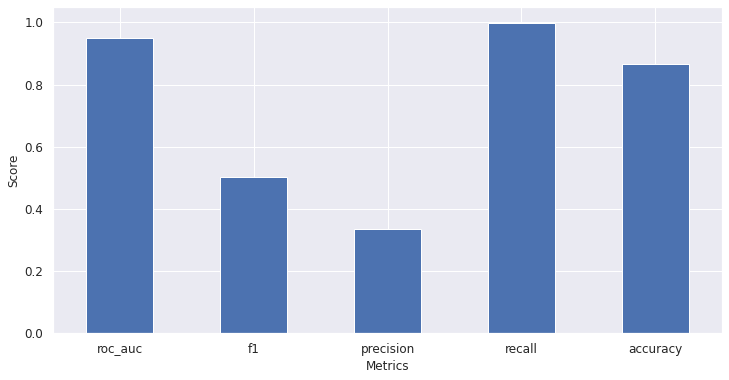

In [ ]:
ax = mean_df.plot(kind='bar', rot=0, figsize=(12, 6), fontsize=12)
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
plt.savefig('test-result.pdf', dpi=600)

# Feature Importance

In [ ]:
feature_importances = []
for pipeline in cross_validatation_scores['estimator']:
  model = pipeline['model']
  feature_importances.append(model.feature_importances_)

In [ ]:
feature_importance = np.mean(feature_importances, axis=0)
feature_importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importance})
feature_importance_df['Importance'] = feature_importance_df['Importance'] * 100 / feature_importance_df['Importance'].sum()
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_df.head(10)

,Feature,Importance
0,bwd_init_window_size,7.183333
1,fwd_pkts_payload.max,4.700000
2,bwd_iat.min,3.930000
3,fwd_iat.min,3.810000
4,fwd_subflow_bytes,3.113333
5,fwd_pkts_payload.tot,3.103333
6,fwd_pkts_payload.min,2.870000
7,bwd_bulk_rate,2.866667
8,flow_pkts_payload.avg,2.793333
9,down_up_ratio,2.493333


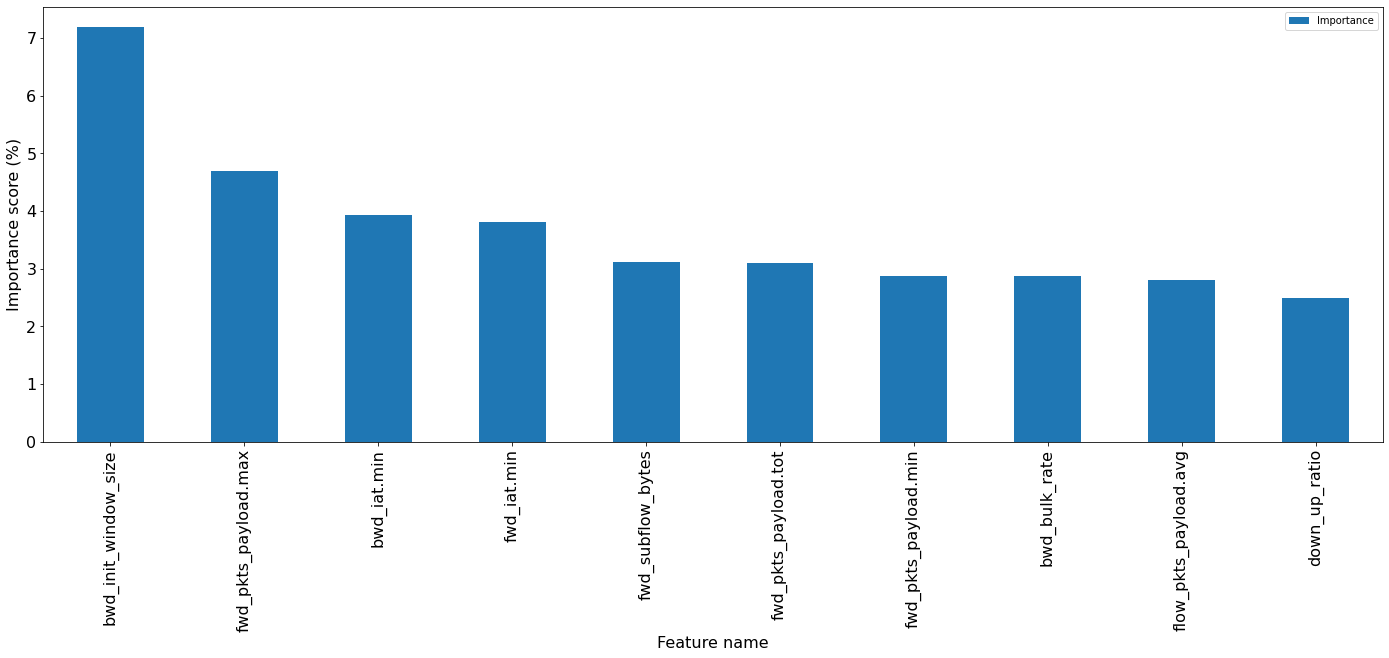

In [ ]:
# feature_importance_df.set_index('Feature', inplace=True)
fontsize = 16
ax = feature_importance_df.iloc[:10, :].plot(kind='bar', figsize=(24, 8), fontsize=fontsize)
ax.set_xlabel('Feature name', fontsize=fontsize)
ax.set_ylabel('Importance score (%)', fontsize=fontsize)
plt.savefig('feature-importance.png', dpi=600)

# ROC-AUC Curve

In [ ]:
from IPython.core.pylabtools import figsize
def plot_roc_auc(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    roc_auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc-auc-curve.pdf', dpi=600)
    plt.show()
    return thresholds[ix]

In [ ]:
y_probs = []
for run, pipeline in enumerate(cross_validatation_scores['estimator']):
  model = pipeline['model']
  y_prob = model.predict_proba(x_test)[:, -1]
  y_probs.append(y_prob)

In [ ]:
y_prob_mean = np.mean(y_probs, axis=0)

Best Threshold=0.457360, G-Mean=0.924


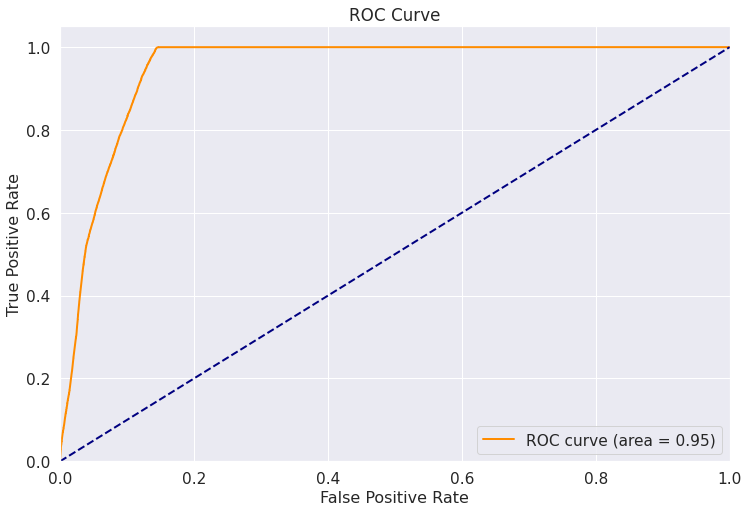

In [ ]:
plt.rcParams.update({'font.size': 16})
best_threshold = plot_roc_auc(y_test, y_prob_mean)

In [ ]:
result(y_test, y_prob_mean, threshold=best_threshold)

AUC 0.9483, F1 0.5024, Precision 0.3356, Recall 0.9995, Accuracy 0.8646


(0.9483494279584965,
 0.5024317617866005,
 0.335557716103942,
 0.9994734763722523,
 0.8645818325889641)

In [ ]:
scores = []
for threshold in range(1, 91):
  scores.append(result(y_test, y_prob_mean, threshold=threshold*0.01, verbose=False))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

In [ ]:
scores_df = pd.DataFrame(scores)
scores_df.columns = scoring

In [ ]:
scores_df.to_csv('threshold.csv', index=False)

In [ ]:
scores_df = pd.read_csv('threshold.csv')

In [ ]:
scores_df['threshold'] = scores_df.index * 0.01

In [ ]:
scores_df = scores_df.set_index('threshold')

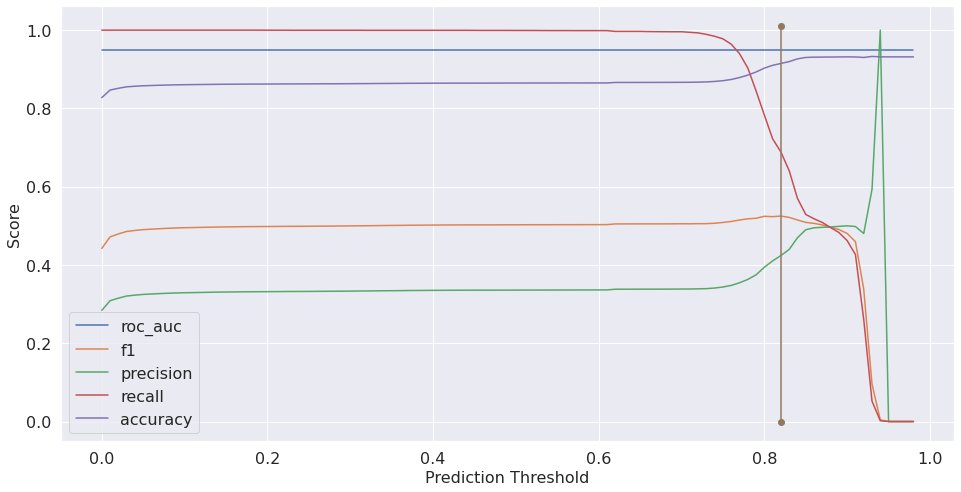

In [ ]:
fontsize = 16
ax = scores_df.plot(kind='line', rot=0, figsize=(16, 8), fontsize=fontsize)
plt.plot([0.82, 0.82], [0, 1.01], marker = 'o')
ax.set_xlabel('Prediction Threshold', fontsize=fontsize)
ax.set_ylabel('Score', fontsize=fontsize)
ax.legend(loc='lower left', fontsize=fontsize)
plt.savefig('threshold.pdf', dpi=600)

In [ ]:
scores_df[scores_df['f1']==scores_df['f1'].max()]

,roc_auc,f1,precision,recall,accuracy
82,0.948349,0.524911,0.424112,0.688561,0.914737


In [ ]:
best_threshold = 0.82
result(y_test, y_prob_mean, threshold=best_threshold)

AUC 0.9483, F1 0.5233, Precision 0.4103, Recall 0.7223, Accuracy 0.9100


(0.9483494279584965,
 0.5233439839763461,
 0.410335028417589,
 0.7222587863630381,
 0.9100003601786486)

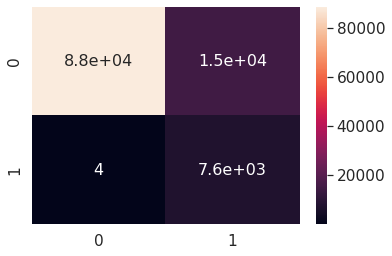

In [ ]:
import seaborn as sn
confusion = confusion_matrix(y_test, y_prob_mean>=best_threshold)
df_cm = pd.DataFrame(confusion)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin